## Análisis y Filtrado de Señales Electrocardiográficas (ECG) mediante la Transformada de Fourier para la Identificación de Ritmos Anómalos

- Maria Paula Carvajal Martinez
- Melissa Forero Narvaez
- Daniel Alberto Garzón Fraile

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import wfdb

<a id='import'></a>
### Lectura de señales

Utilizaremos el paquete waveform-database (`wfdb`) para leer nuestros archivos. Existen múltiples métodos para leer las señales de ECG, a continuación utilizaremos `rdrecord` y `rdsamp`.

Veamos primero un registro de ECG:

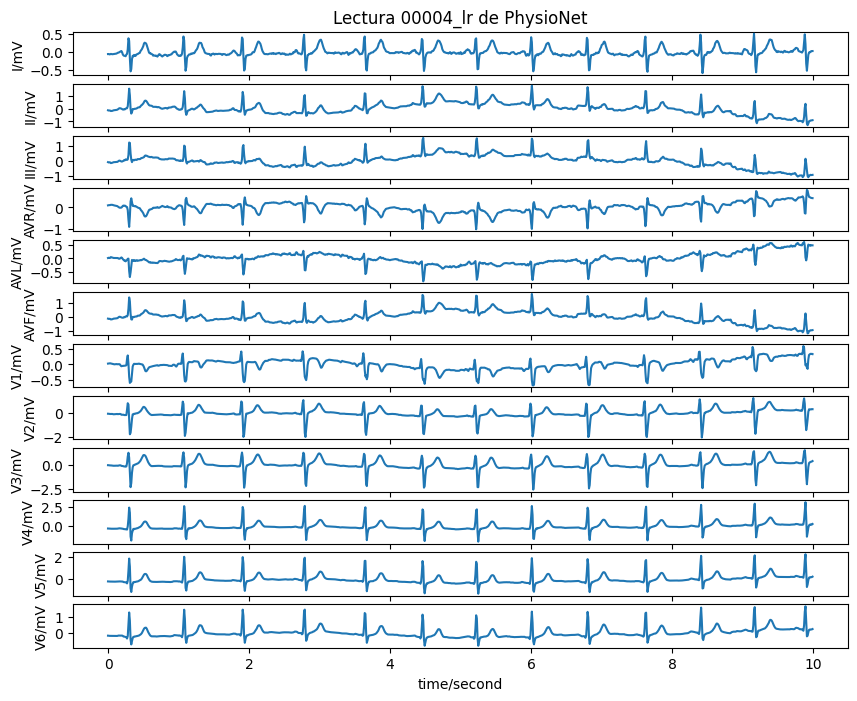

In [19]:
# ECG file path
path = 'data/ptb-xl/records100/00000/'
ecg = '00004_lr'
file = path + ecg

# Read record
record = wfdb.rdrecord(file)

# Plot ECG signals
wfdb.plot_wfdb(record=record, title=f'Lectura {ecg} de PhysioNet', figsize=(10,8))
# display(record.__dict__)

<a id='signal'></a>
Si observamos el gráfico anterior, veremos que cada registro de ECG contiene en realidad 12 señales, ya que estamos trabajando con ECG de 12 derivaciones. Veamos más de cerca el aspecto de una derivación del ECG. Cargaremos la derivación II.

Metadata: 
 {'fs': 100, 'sig_len': 1000, 'n_sig': 1, 'base_date': None, 'base_time': None, 'units': ['mV'], 'sig_name': ['II'], 'comments': []}


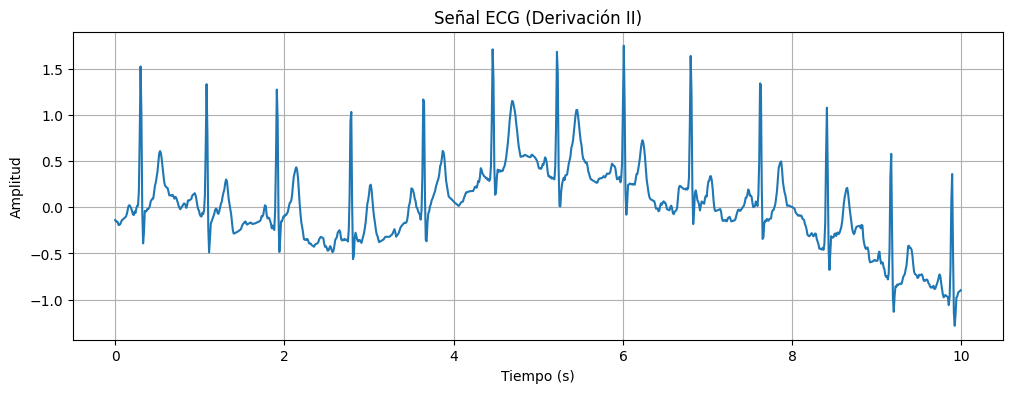

In [20]:
# Read lead II
signals, fields = wfdb.rdsamp(file, channels=[1])  # channels = leads

# Print metadata
print("Metadata: \n", fields)

sampling_frequency = fields['fs']  # Sampling frequency
sig_len = fields['sig_len'] # Signal length 
sig_name = fields['sig_name'] # Lead

# Convert to time series
time = np.arange(0, sig_len) / sampling_frequency

# Plot the ECG signal
plt.figure(figsize=(12, 4))
plt.plot(time, signals)
plt.title('Señal ECG (Derivación {})'.format(sig_name[0]))
plt.xlabel('Tiempo (s)')
plt.ylabel('Amplitud')
plt.grid(True)
plt.show()

Vemos que en la derivación II, la señal tiene una onda general junto con algún artefacto.

<a id='fourier'></a>
### Análisis de Fourier

Para comprender mejor nuestras señales, primero necesitamos un método para limpiarlas. **La transformada de Fourier** es un método de transformación de señales de series temporales en señales basadas en la frecuencia. En lugar de tener el tiempo en el eje x, podemos transformarlo en frecuencia. La ventaja de este método es que permite eliminar el ruido de alta y baja frecuencia de las señales de ECG. A menudo, las señales de ECG se ven oscurecidas por el ruido durante el proceso de grabación, lo que da lugar a registros deficientes. Las transformadas de Fourier pueden ayudar a solucionar este problema eliminando esos ruidos.

A continuación presentamos unos gráficos sencillos para explicar las transformadas de Fourier.

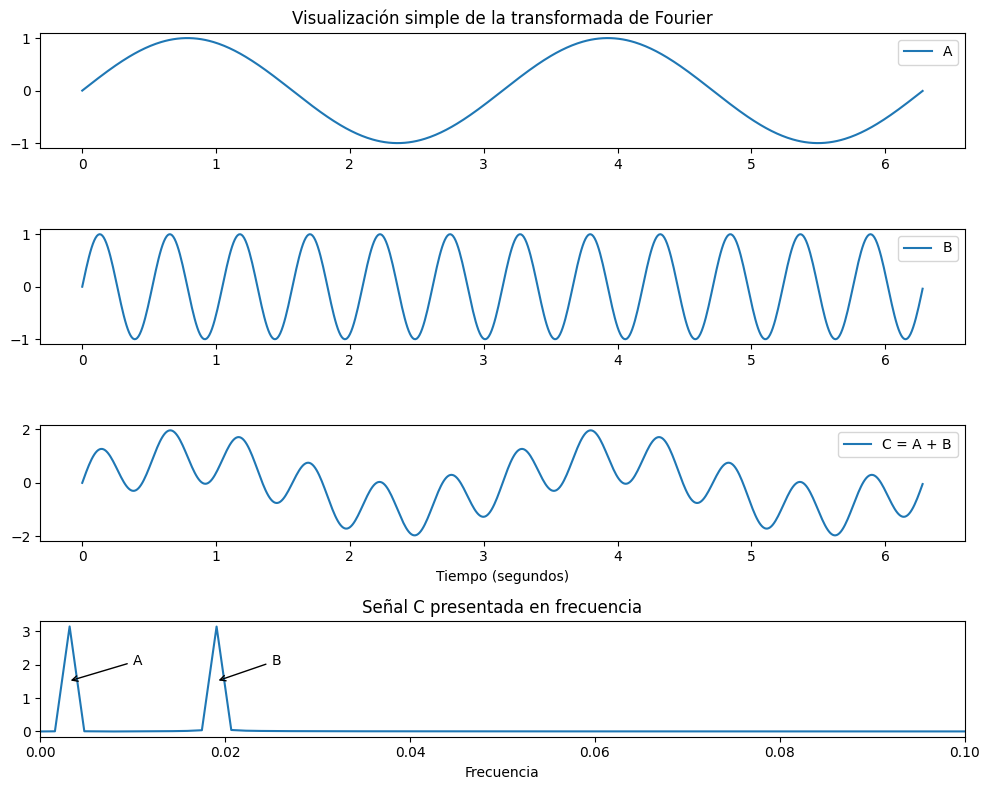

In [21]:
# Creating subplots
fig, ax = plt.subplots(nrows=4, ncols=1, figsize=(10,8))

# One period cycle
t = np.arange(0, 2*np.pi, 0.01)

# Convert to to frequency
f = np.fft.fftshift(np.fft.fftfreq(len(t)))

# Fourier transform signal 
sig = np.fft.fftshift(np.fft.fft(np.sin(2*t)+np.sin(12*t)) * 0.01)

# Plot signals individually and together
ax[0].plot(t, np.sin(2*t), label='A')
ax[1].plot(t, np.sin(12*t), label='B')
ax[2].plot(t, np.sin(2*t)+np.sin(12*t), label='C = A + B')
ax[3].plot(f, np.abs(sig))

ax[0].set_title("Visualización simple de la transformada de Fourier")
ax[0].legend()
ax[1].legend()
ax[2].set_xlabel("Tiempo (segundos)")
ax[2].legend()
ax[3].set_title("Señal C presentada en frecuencia")
ax[3].set_xlabel("Frecuencia")
ax[3].set_xlim(0, 0.1)
ax[3].annotate("A", (0.003, 1.5), xytext=(0.01, 2), arrowprops=dict(arrowstyle="->", facecolor='black'))
ax[3].annotate("B", (0.019, 1.5), xytext=(0.025, 2), arrowprops=dict(arrowstyle="->", facecolor='black'))

fig.tight_layout()


**Explicación**:
1. Si observamos los gráficos anteriores, tenemos dos ondas sinusoidales o señales, A y B. Estas dos señales tienen frecuencias diferentes.
2. Si sumamos A y B, obtenemos C.
3. Este concepto puede generalizarse:
    - Cualquier señal complicada (periódica) que sea como C puede descomponerse en otras más simples de diferentes frecuencias, como lo que tenemos aquí con A y B. 
4. Si observamos C en términos de frecuencia, vemos que hay dos picos. Estos representan las frecuencias que componen la señal C.
    - Guess what, this is just the frequency of signal A and signal B!! 
    
Este es el concepto fundamental que estamos utilizando. Nuestras señales de ECG son como la señal C, complicadas y llenas de ruido. Si descomponemos nuestra señal y miramos sus frecuencias constituyentes, podemos eliminar específicamente aquellas frecuencias que están asociadas con el ruido.

Para aplicar este concepto a nuestras señales de ECG, utilizamos la Transformada Rápida de Fourier (FFT) que NumPy tiene disponible.

**Prueba 1**
- Pruebas de FFT en ECG.

Volvamos a la señal que importamos por primera vez [aqui](#signal). Primero, obtenemos el intervalo de muestreo, $T$. Sabemos que $T = \frac{1}{f_s}$ donde $f_s$ es la frecuencia de muestreo. 

In [22]:
# First we get the sampling interval 
dt = 1/sampling_frequency

Debemos tener en cuenta que la señal de ECG se da en una matriz 2D. Tenemos que convertirla a 1D antes de aplicar la FFT

In [23]:
# Flatten the signal from 2D to 1D 
signals = signals.flatten()

Por último, podemos calcular la FFT y representarla gráficamente

In [24]:
# FFT returns a result not centered at zero, therefore we need to fftshift it to zero
signal_fft = np.fft.fftshift(np.fft.fft(signals) * dt)

# Convert time sample size to frequency
freq = np.fft.fftshift(np.fft.fftfreq(sig_len, dt))

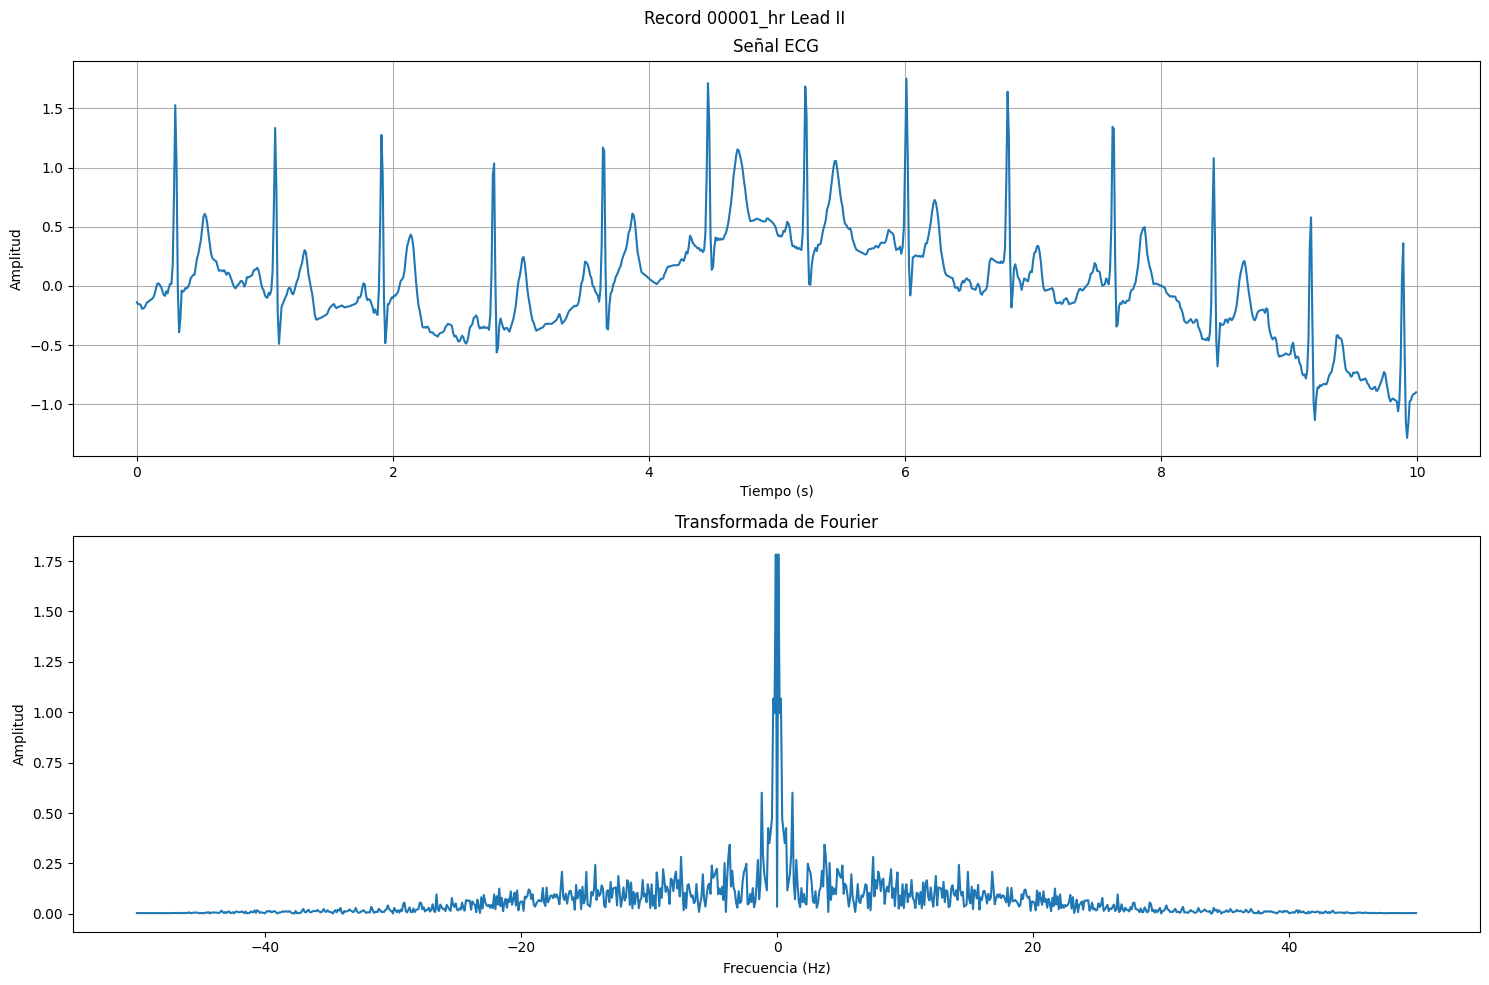

In [25]:
# Plot original time series and fourier transformed version
fig, ax = plt.subplots(2, 1, figsize=(15,10))

fig.suptitle("Record 00001_hr Lead %s" % (sig_name[0]))
ax[0].plot(time, signals)
ax[0].set_title('Señal ECG')
ax[0].set_xlabel('Tiempo (s)')
ax[0].set_ylabel('Amplitud')
ax[0].grid(True)
ax[1].plot(freq, np.abs(signal_fft))
ax[1].set_xlabel('Frecuencia (Hz)')
ax[1].set_ylabel('Amplitud')
ax[1].set_title('Transformada de Fourier')
#ax[1].set_xlim(-100, 100)
fig.tight_layout()
 
fig.savefig('ecg_fft_example.jpg')

Vemos que en el espacio de Fourier, tenemos una estructura en forma de flecha, donde la mayor parte de la señal de ECG contiene ondas de baja frecuencia. Naturalmente, las frecuencias van de negativas a positivas, simplemente están diciendo lo mismo.

**Prueba 2**
- Intentemos hacer lo mismo con la derivación V4, que tiene menos artefactos o ruido.

In [26]:
# Read signal and metadata
signals, fields = wfdb.rdsamp(file, channels=[9])  # Change channels=[0]

sampling_frequency = fields['fs']  # Sampling frequency
sig_len = fields['sig_len'] # Signal length 
sig_name = fields['sig_name'] # Lead

# Print metadata
print("Metadata: \n", fields)

# Convert to time series
time = np.arange(0, sig_len) / sampling_frequency

Metadata: 
 {'fs': 100, 'sig_len': 1000, 'n_sig': 1, 'base_date': None, 'base_time': None, 'units': ['mV'], 'sig_name': ['V4'], 'comments': []}


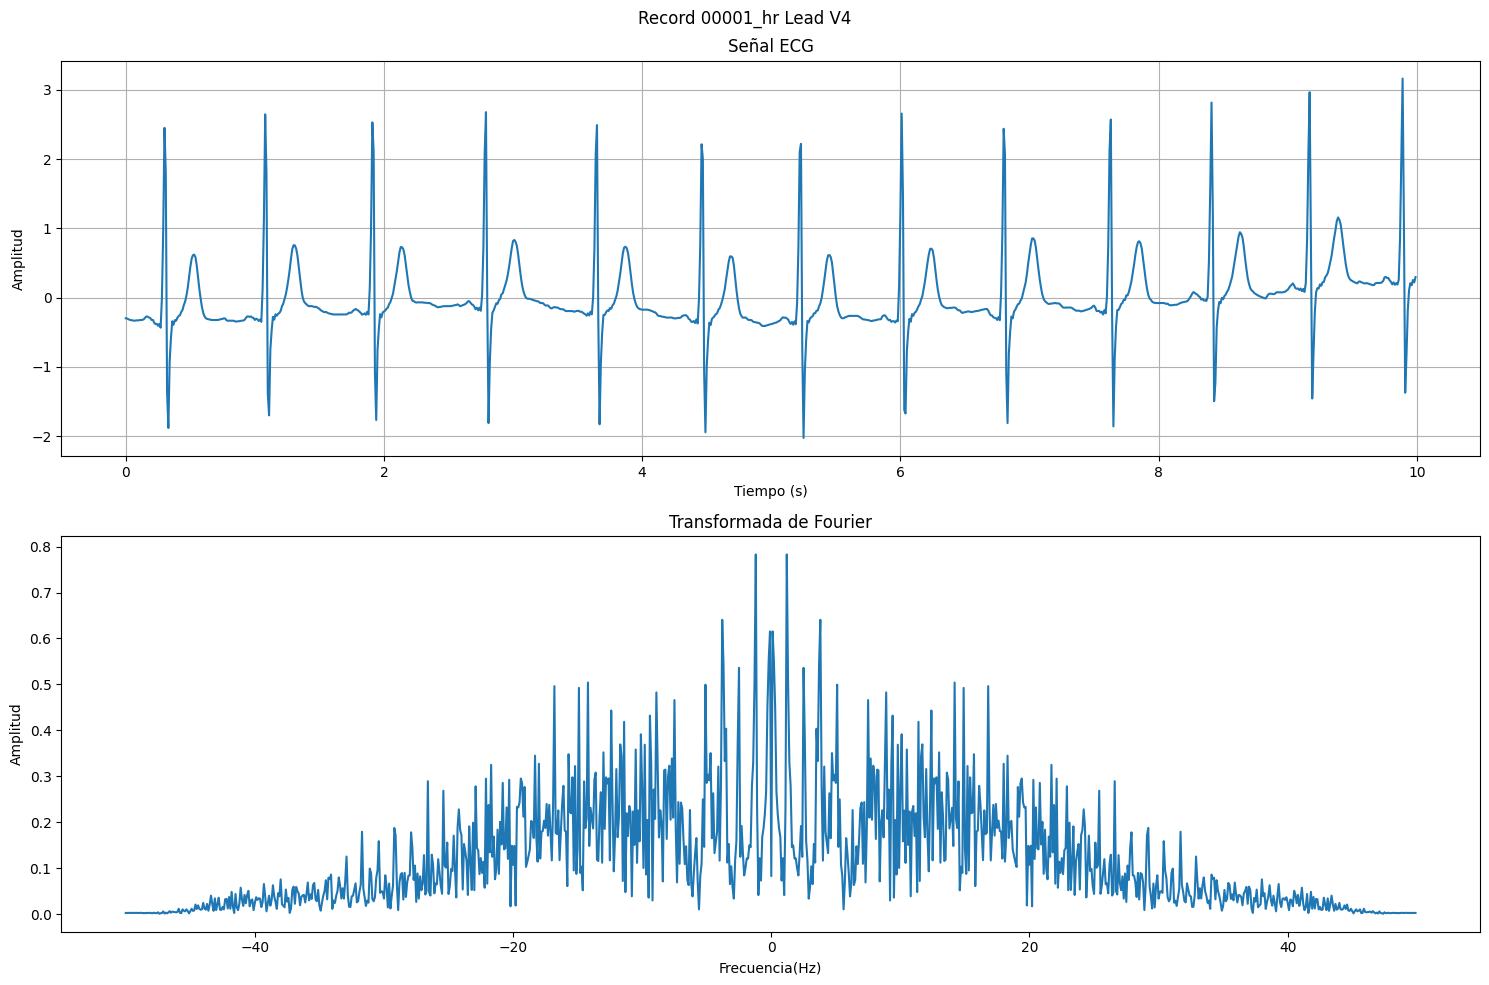

In [27]:
# First we get the sampling interval 
dt = 1/sampling_frequency

# Flatten the signal from 2D to 1D 
signals = signals.flatten()

# FFT returns a result not centered at zero, therefore we need to fftshift it to zero
signal_fft = np.fft.fftshift(np.fft.fft(signals) * dt)
freq = np.fft.fftshift(np.fft.fftfreq(sig_len, dt))

# Subplot
fig, ax = plt.subplots(2, 1, figsize=(15,10))

fig.suptitle("Record 00001_hr Lead %s" % (sig_name[0]))
ax[0].plot(time, signals)
ax[0].set_title('Señal ECG')
ax[0].set_xlabel('Tiempo (s)')
ax[0].set_ylabel('Amplitud')
ax[0].grid(True)
ax[1].plot(freq, np.abs(signal_fft))
ax[1].set_xlabel('Frecuencia(Hz)')
ax[1].set_ylabel('Amplitud')
ax[1].set_title('Transformada de Fourier')
#ax[1].set_xlim(0, 100)
fig.tight_layout()
 
fig.savefig('')

En este ejemplo, vemos que con un ECG que tiene menos fluctuación, en el espacio de Fourier abarca un rango más amplio.

<a id='baseline'></a>
### Eliminación de linea base
Aplicaremos la eliminación de la línea de base mediante el método FFT-IFFT. En muchas mediciones, como electrocardiogramas (ECG), la señal de interés puede estar acompañada por artefactos o componentes que no son relevantes para el análisis. 

Digamos que queremos eliminar una frecuencia base de $f=0$ to $f=1.5$, tenemos que encontrar los índices correspondientes en nuestro conjunto de datos para ponerlos a cero.

In [28]:
# Frequency removal range
freq_start = 0
freq_stop = 1.5
freq_step = 0.1 

baseline_freq = np.arange(freq_start, freq_stop, freq_step)
baseline_freq

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2,
       1.3, 1.4])

De nuevo utilizaremos la misma señal que en el ejemplo 1, **excepto** que esta vez utilizaremos la versión de alta frecuencia de muestreo, ($f_s = 500$ Hz).

Metadata: 
 {'fs': 500, 'sig_len': 5000, 'n_sig': 1, 'base_date': None, 'base_time': None, 'units': ['mV'], 'sig_name': ['II'], 'comments': []}


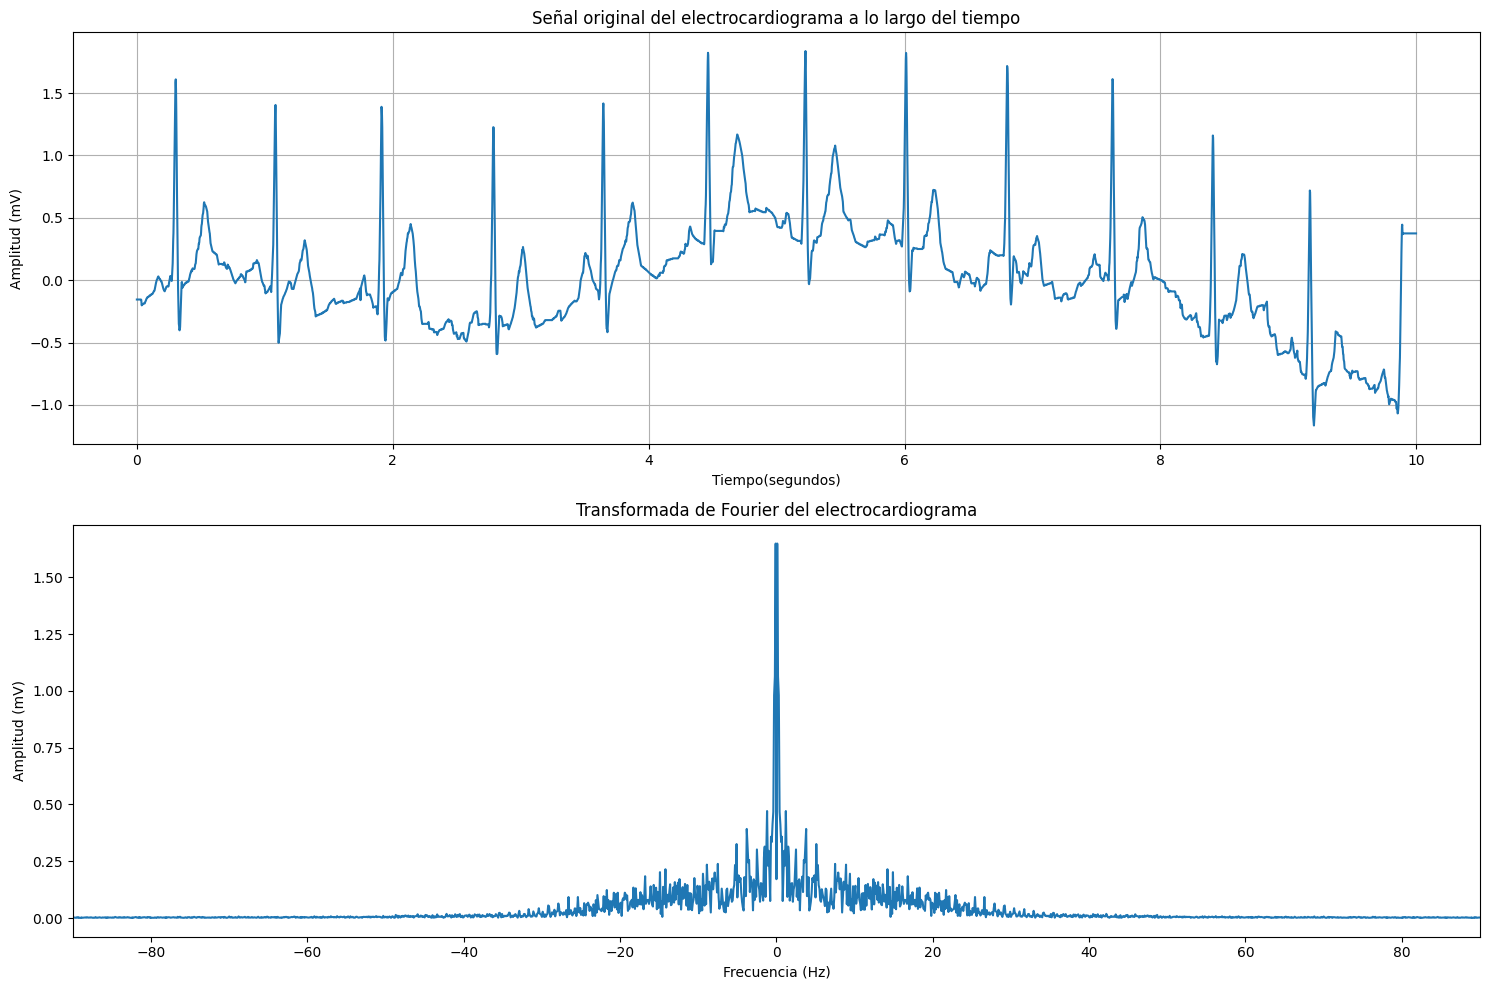

In [29]:
# File path for high frequency sampling
path = 'data/ptb-xl/records500/00000/'
file = path+'00004_hr'

# Read signal and metadata
signals, fields = wfdb.rdsamp(file, channels=[1])  # Channels = Leads

sampling_frequency = fields['fs']  # Sampling frequency
sig_len = fields['sig_len'] # Signal length 
sig_name = fields['sig_name'] # Lead

# Print metadata
print("Metadata: \n", fields)

# Convert to time series
time = np.arange(0, sig_len) / sampling_frequency

# First we get the sampling interval 
dt = 1/sampling_frequency

# Flatten the signal from 2D to 1D 
signals = signals.flatten()

# FFT returns a result not centered at zero, therefore we need to fftshift it to zero
signal_fft = np.fft.fftshift(np.fft.fft(signals) * dt)
freq = np.fft.fftshift(np.fft.fftfreq(sig_len, dt))

fig, ax = plt.subplots(2, 1, figsize=(15,10))

#fig.suptitle("Record 00001_hr Lead %s" % (sig_name[0]))
ax[0].plot(time, signals)
ax[0].set_title('Señal original del electrocardiograma a lo largo del tiempo')
ax[0].set_xlabel('Tiempo(segundos)')
ax[0].set_ylabel('Amplitud (mV)')
ax[0].grid(True)
ax[1].plot(freq, np.abs(signal_fft))
ax[1].set_xlabel('Frecuencia (Hz)')
ax[1].set_ylabel('Amplitud (mV)')
ax[1].set_title('Transformada de Fourier del electrocardiograma')
ax[1].set_xlim(-90, 90)
fig.tight_layout()
plt.savefig('signal_and_fft.jpg')

Ahora eliminaremos las frecuencias que especificamos anteriormente. Para ello, primero tomaremos una copia de nuestros datos y lo realizaremos en la copia, para que podamos ver la diferencia antes y después. Sabiendo qué frecuencias queremos eliminar, necesitamos traducir esto a qué índices eliminar en nuestros datos de 5000 puntos de muestra.

In [30]:
#### BASELINE REMOVAL 

test_signal_fft = signal_fft.copy()

# Frequency removal range
freq_start = 0.1
freq_stop = 1.5
#freq_stop = freq[-1]
freq_step = 0.1 

for i in range(len(freq)):
    
    if (freq[i] >= freq_start) & (freq[i] <= freq_stop):
        
        # Set positive frequencies to zero 
        test_signal_fft[i] = 0
    
    elif (freq[i] >= -freq_stop) & (freq[i] <= -freq_start):
        
        # Set negative frequencies to zero 
        test_signal_fft[i] = 0

Trazado de la señal original en el espacio de Fourier y después de eliminar las frecuencias especificadas.

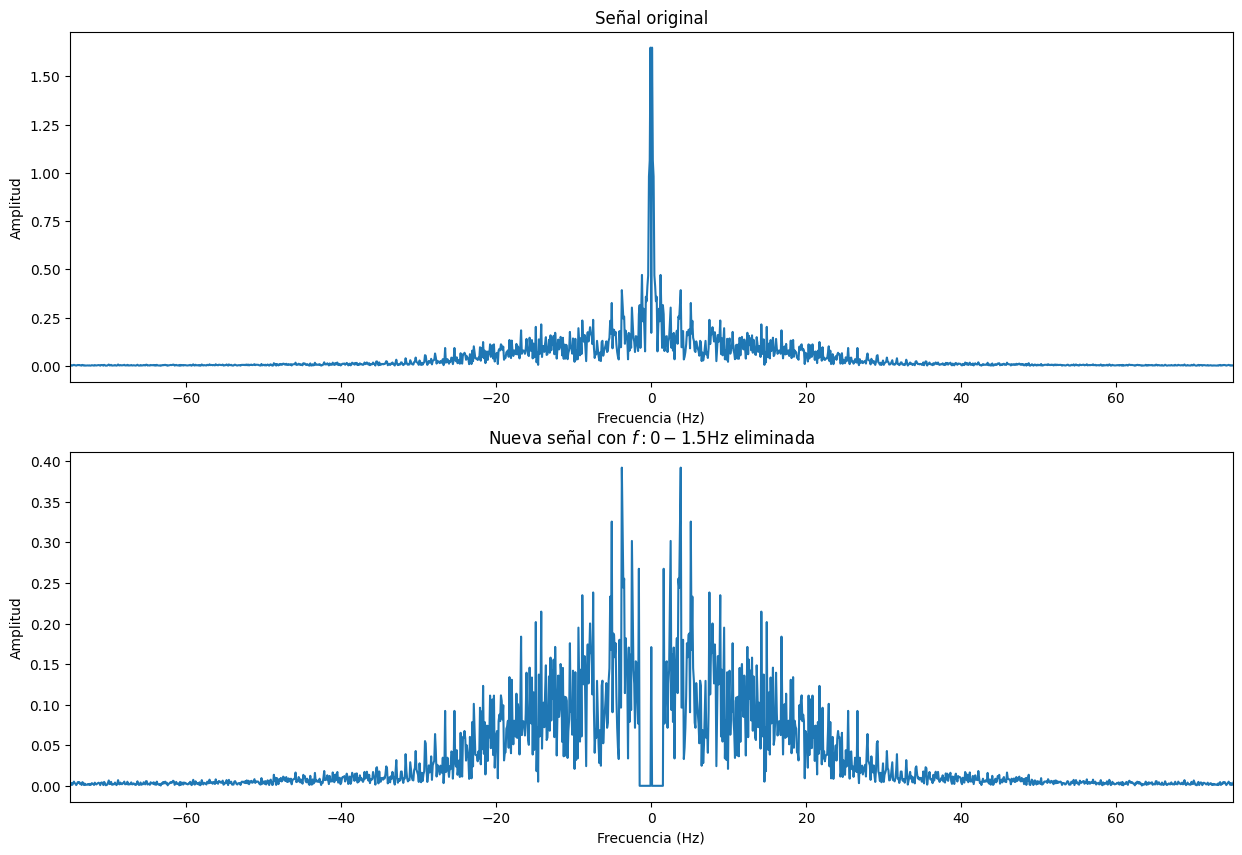

In [31]:
# Before and after frequency removal 
fig, ax = plt.subplots(2, 1, figsize=(15,10))

ax[0].plot(freq, np.abs(signal_fft))
ax[0].set_title('Señal ECG')
ax[0].set_xlabel('Frecuencia (Hz)')
ax[0].set_ylabel('Amplitud')
ax[0].set_title(r"Señal original")
ax[0].set_xlim(-75, 75)
ax[1].plot(freq, np.abs(test_signal_fft))
ax[1].set_title('Señal ECG')
ax[1].set_xlabel('Frecuencia (Hz)')
ax[1].set_ylabel('Amplitud')
ax[1].set_title(r"Nueva señal con $f: 0-1.5 \rm Hz$ eliminada")
ax[1].set_xlim(-75, 75);

Ahora trazaremos las señales con y sin eliminación de frecuencia.

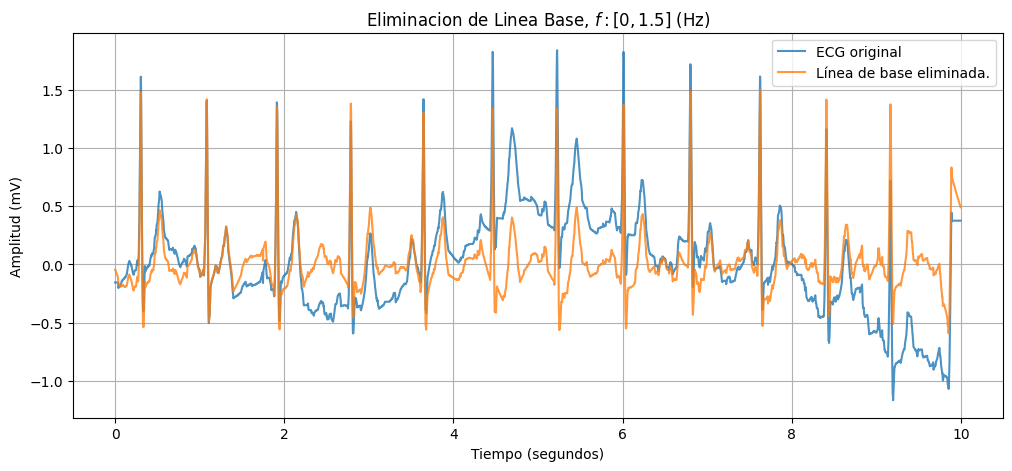

In [32]:
# Inverse FFT our signal back to the time domain
new_signal = np.fft.ifft(np.fft.ifftshift(test_signal_fft)) / dt

# Plot
plt.figure(figsize=(12,5))
plt.plot(time, signals, label="ECG original", alpha=0.8)
plt.plot(time, np.real(new_signal), label="Línea de base eliminada.", alpha=0.8)
plt.title(f"Eliminacion de Linea Base, $f: [0, 1.5]$ (Hz)")
plt.xlabel("Tiempo (segundos)")
plt.ylabel("Amplitud (mV)")
plt.grid(True)
plt.legend()
#plt.tight_layout()
plt.savefig("baseline_fft.jpg")

plt.show()

Del gráfico anterior, podemos ver que nuestra eliminación de frecuencia inicial de $f=0$ to $f=1.5 $ Hz nos ayuda a reducir nuestra señal para que tenga una estructura menos ondulada. 

<a id='high_freq'></a>
### Eliminación de altas frecuencias

A continuación intentaremos eliminar el ruido de alta frecuencia de nuestros datos. El ruido de alta frecuencia en las señales de ECG puede deberse a cosas como la interferencia de la línea eléctrica o el ruido muscular.

Primero intentaremos eliminar el ruido de alta frecuencia que vemos **visualmente**, es decir, la frecuencia superior a 40 Hz. Podemos reutilizar nuestro código anterior que usamos para la línea de base y sólo cambiar los componentes de frecuencia que estamos eliminando.

In [33]:
# Frequency removal range
freq_start = 40
#freq_stop = 55
freq_stop = freq[-1] # till the highest frequency 
freq_step = 0.1 

for i in range(len(freq)):
    
    if (freq[i] >= freq_start) & (freq[i] <= freq_stop):
        
        # Set positive frequencies to zero 
        test_signal_fft[i] = 0
    
    elif (freq[i] >= -freq_stop) & (freq[i] <= -freq_start):
        
        # Set negative frequencies to zero 
        test_signal_fft[i] = 0

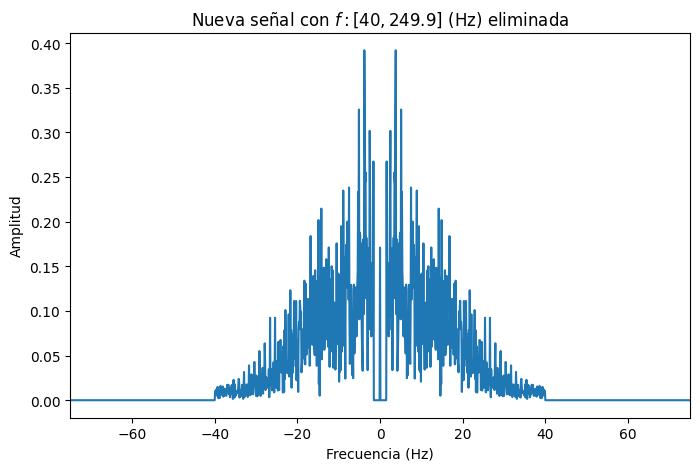

In [34]:
plt.figure(figsize=(8,5))
plt.plot(freq, np.abs(test_signal_fft))
plt.title('Señal ECG')
plt.xlabel('Frecuencia (Hz)')
plt.ylabel('Amplitud')
plt.title(f"Nueva señal con $f: [{freq_start}, {freq_stop}]$ (Hz) eliminada")
plt.xlim(-75, 75)
plt.show()

In [35]:
# Inverse FFT our signal THAT ALSO GOT HIGH FREQ REMOVED back to the time domain
new_signal_pli = np.fft.ifft(np.fft.ifftshift(test_signal_fft)) / dt

In [36]:
signals.shape

(5000,)

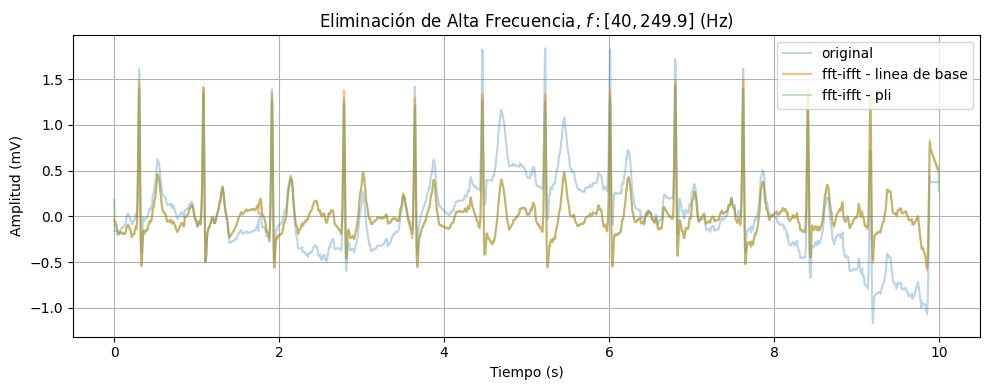

In [37]:
# Plot
plt.figure(figsize=(10,4))
plt.plot(time, signals, label="original", alpha=0.3)
plt.plot(time, np.real(new_signal), label="fft-ifft - linea de base", alpha=0.5)
plt.plot(time, np.real(new_signal_pli), label="fft-ifft - pli", alpha=0.3)
plt.title(f"Eliminación de Alta Frecuencia, $f: [{freq_start}, {freq_stop}]$ (Hz)")
plt.xlabel("Tiempo (s)")
plt.ylabel("Amplitud (mV)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig("baseline_fft.jpg")
#plt.xlim(1, 3)
plt.show()

#### Implementación de la función

Por último, podemos implementar la función en nuestras señales. Vamos a dividir para tener una función `baseline_removal` para eliminar la línea de base errante y otra función `high_freq_removal` para eliminar las señales de alta frecuencia, como la interferencia de línea eléctrica.

In [39]:
def high_freq_removal(sig, freq_start, freq_stop=freq[-1], signal_samp_freq='low'):
    
    ##### PARAMETER SETTING
    
    # High Frequency Parameters
    if signal_samp_freq == 'high':
        sampling_freq = 500
        sig_len = 5000
    else: 
        # Low Frequency Parameters
        sampling_freq = 100
        sig_len = 1000
        
    # Set stepsize 
    dt = 1/sampling_freq
    
    # Flatten the signal from 2D to 1D 
    sigs = sig.flatten()
    
    ##### FFT SIGNAL
    
    # FFT returns a result not centered at zero, therefore we need to fftshift it to zero
    sig_fft = np.fft.fftshift(np.fft.fft(sigs) * dt)
    freq = np.fft.fftshift(np.fft.fftfreq(sig_len, dt))
    
    ##### HIGH FREQUENCY REMOVAL 
    for i in range(len(freq)):
        
        # Setting positive frequencies to zero
        if (freq[i] >= freq_start) & (freq[i] <= freq_stop):
 
            sig_fft[i] = 0

        # Setting negative frequencies to zero
        elif (freq[i] >= -freq_stop) & (freq[i] <= -freq_start):

            sig_fft[i] = 0
    
    ##### IFFT SIGNAL
    
    new_sig = np.fft.ifft(np.fft.ifftshift(sig_fft)) / dt
    
    return new_sig

### Pruebas de las funciones anteriores

Vamos a probar ambas funciones con la señal de muestra que teníamos arriba.

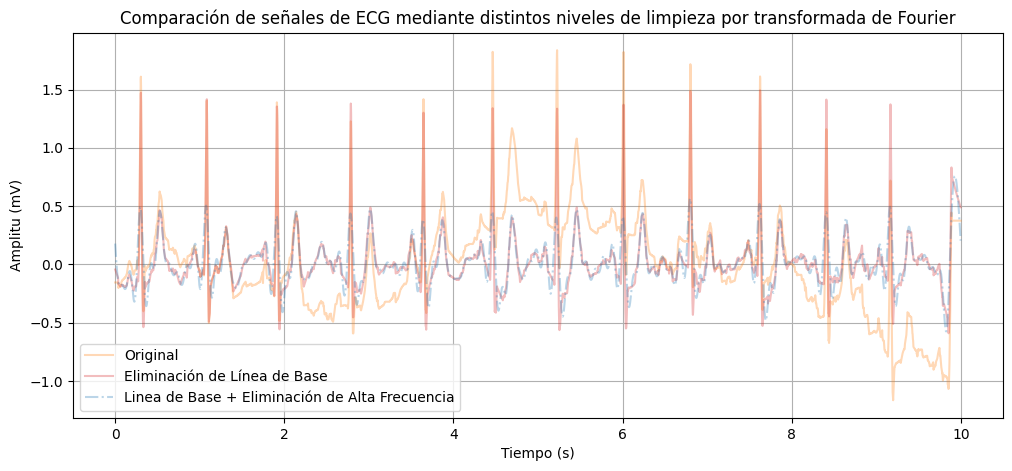

In [40]:
signals, fields = wfdb.rdsamp(file, channels=[1])  # Channels = Leads

samp_signal = signals.copy()

sig_len = 5000
sampling_frequency = 500
time = np.arange(0, sig_len) / sampling_frequency

samp_signal_bl = baseline_removal(samp_signal, freq_start=0.1, freq_stop=1.5, signal_samp_freq='high')
samp_signal_pli = high_freq_removal(samp_signal_bl, freq_start=10, signal_samp_freq='high')

plt.figure(figsize=(12, 5))
plt.plot(time, samp_signal, alpha=0.3, c='C1', label='Original')
plt.plot(time, np.real(samp_signal_bl), alpha=0.3, c='C3', label='Eliminación de Línea de Base')
plt.plot(time, np.real(samp_signal_pli), alpha=0.3, c='C0', ls='-.', label='Linea de Base + Eliminación de Alta Frecuencia')
plt.title("Comparación de señales de ECG mediante distintos niveles de limpieza por transformada de Fourier")
plt.xlabel("Tiempo (s)")
plt.ylabel("Amplitu (mV)")
plt.grid(True)
plt.legend()
#plt.tight_layout()
plt.savefig('full_fft_ecg.jpg')
plt.show()

### Detección de ritmos anomalos

Vamos a probar ambas funciones con la señal de muestra que teníamos arriba.

In [41]:
# Función básica para identificar ritmos anómalos en ECG
def detectar_ritmo_anomalo(signal, fs, umbral_taquicardia=100, umbral_bradicardia=60):
    """
    signal: array 1D de la señal ECG (ya filtrada y en 1D)
    fs: frecuencia de muestreo (Hz)
    umbral_taquicardia: frecuencia cardíaca mínima para taquicardia (lpm)
    umbral_bradicardia: frecuencia cardíaca máxima para bradicardia (lpm)
    """
    # Detección de picos (QRS) usando un umbral simple
    from scipy.signal import find_peaks
    # Normalizar señal
    sig_norm = (signal - np.mean(signal)) / np.std(signal)
    # Buscar picos (QRS)
    peaks, _ = find_peaks(sig_norm, distance=int(0.3*fs), height=0.5)
    # Calcular intervalos RR
    rr_intervals = np.diff(peaks) / fs
    # Calcular frecuencia cardíaca promedio
    if len(rr_intervals) == 0:
        return 'No se detectaron latidos'
    hr = 60 / np.mean(rr_intervals)
    # Clasificación básica
    if hr > umbral_taquicardia:
        return f'Taquicardia detectada: {hr:.1f} lpm'
    elif hr < umbral_bradicardia:
        return f'Bradicardia detectada: {hr:.1f} lpm'
    else:
        # Buscar variabilidad excesiva en RR (arritmia)
        if np.std(rr_intervals) > 0.12:
            return f'Arritmia detectada: FC {hr:.1f} lpm'
        else:
            return f'Ritmo normal: {hr:.1f} lpm'

In [42]:
# Ejemplo: aplicar la función a otro registro de la base de datos PTB-XL
path = 'data/ptb-xl/records100/00000/'
ecg = '00004_lr'  # Cambia el nombre para probar otro registro
file = path + ecg

# Leer la señal de la derivación II
signals, fields = wfdb.rdsamp(file, channels=[1])
sampling_frequency = fields['fs']

# Aplanar la señal si es necesario
signals = signals.flatten()

# Identificar ritmo anómalo
resultado = detectar_ritmo_anomalo(signals, sampling_frequency)
print(f'Registro: {ecg} | Resultado: {resultado}')

Registro: 00004_lr | Resultado: Arritmia detectada: FC 87.6 lpm


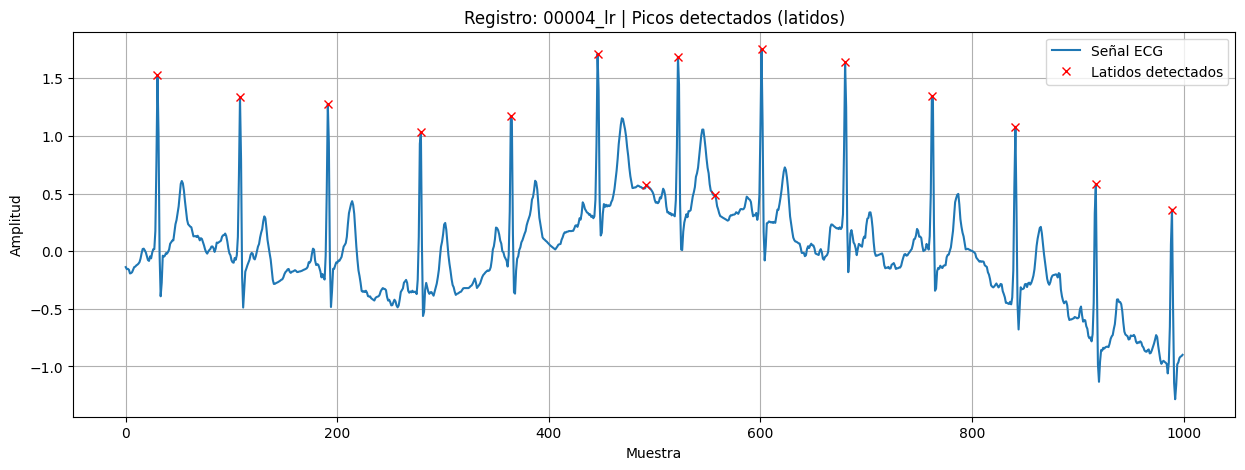

Frecuencia cardíaca estimada: 87.6 lpm


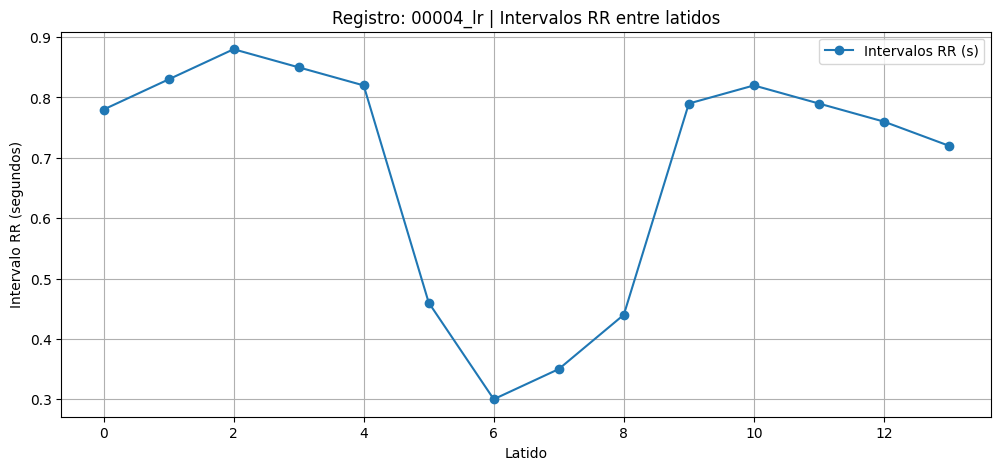

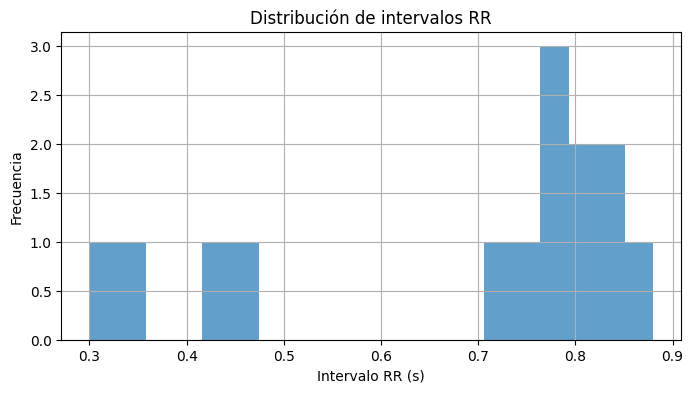

Desviación estándar de RR: 0.195 s
Variabilidad alta: posible arritmia


In [43]:
# Visualización de los picos detectados en la señal ECG
from scipy.signal import find_peaks
plt.figure(figsize=(15,5))
plt.plot(signals, label='Señal ECG')
peaks, _ = find_peaks((signals-np.mean(signals))/np.std(signals), distance=int(0.3*sampling_frequency), height=0.5)
plt.plot(peaks, signals[peaks], 'rx', label='Latidos detectados')
plt.title(f'Registro: {ecg} | Picos detectados (latidos)')
plt.xlabel('Muestra')
plt.ylabel('Amplitud')
plt.legend()
plt.grid(True)
plt.show()
print(f'Frecuencia cardíaca estimada: {60/np.mean(np.diff(peaks)/sampling_frequency):.1f} lpm')
# Visualización de los intervalos RR y su variabilidad
from scipy.signal import find_peaks
peaks, _ = find_peaks((signals-np.mean(signals))/np.std(signals), distance=int(0.3*sampling_frequency), height=0.5)
rr_intervals = np.diff(peaks) / sampling_frequency
plt.figure(figsize=(12,5))
plt.plot(rr_intervals, marker='o', linestyle='-', label='Intervalos RR (s)')
plt.title(f'Registro: {ecg} | Intervalos RR entre latidos')
plt.xlabel('Latido')
plt.ylabel('Intervalo RR (segundos)')
plt.grid(True)
plt.legend()
plt.show()
plt.figure(figsize=(8,4))
plt.hist(rr_intervals, bins=20, color='C0', alpha=0.7)
plt.title('Distribución de intervalos RR')
plt.xlabel('Intervalo RR (s)')
plt.ylabel('Frecuencia')
plt.grid(True)
plt.show()
print(f'Desviación estándar de RR: {np.std(rr_intervals):.3f} s')
if np.std(rr_intervals) > 0.12:
    print('Variabilidad alta: posible arritmia')
else:
    print('Variabilidad baja: ritmo regular')